In [2]:
#%matplotlib notebook
import numpy as np
from scipy.signal import decimate
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.interpolate import interp1d
from scipy.signal import resample

In [998]:
# working version detection

class AutoTune():
    
    def __init__(self, wav, sensitivity=.02):
        
        
        assert len(wav) > 8*220
        
        # original audio
        self.wav = np.array(wav)
        
        # 1/8 decimation
        self.down_wav = decimate(self.wav, q=8)
        print(self.down_wav.shape)
        # declare tables
        self.Ei_Table = np.zeros((len(self.down_wav), 111), dtype=float)
        self.Hi_Table = np.zeros((len(self.down_wav), 111), dtype=float)
        self.subTable = np.zeros((len(self.down_wav), 111), dtype=float)
        self.truTable = np.zeros((len(self.down_wav), 111), dtype=float)
        self.real_freq = np.zeros(len(self.wav), dtype=float)
        
        self.idxTable = []
        
        # first value of e table
        for L in range(2,111):
            self.Ei_Table[220,L] = sum(np.square(self.down_wav[221-2*L:221]))
            self.Hi_Table[220,L] = sum(np.multiply(self.down_wav[221-2*L:221-L], self.down_wav[221-L:221]))

        # loop to initialize tables
        for i in range(221, len(self.down_wav)):
            indx = []
            
            for L in range(2,111):
                self.Ei_Table[i, L] = self.Ei_Table[i-1, L] + self.down_wav[i]**2 - self.down_wav[i-2*L]**2
                self.Hi_Table[i, L] = self.Hi_Table[i-1, L] + self.down_wav[i]*self.down_wav[i-L] - self.down_wav[i-L]*self.down_wav[i-2*L]
                self.subTable[i, L] = self.Ei_Table[i, L] - 2*self.Hi_Table[i, L]
                

                #self.truTable[i, L] = self.subTable[i, L]<0.03*A.Ei_Table[i, L]
                if self.subTable[i, L] < sensitivity*self.Ei_Table[i, L] and L > 10 and L < 70:
                    value, freq = self.get_real_freq(i, L)
                    self.real_freq[i*8:(i+1)*8] = freq
                    if not i % 1000:
                        print('i:',i*8,'bigL:',8*L,'freq:',freq)
                    break
                    
                if L == 110:
                    self.real_freq[i*8:(i+1)*8] = self.real_freq[i*8-1]
                    
            
            # append successes to index list
            #self.idxTable.append(indx)
            
            
           
    def get_real_freq(self, down_indx, down_f_est):
        
        # convert to real signal indecies
        real_indx = 8*down_indx
        real_f_est = 8*down_f_est

        # create Ls index to calculate E and H for
        real_line = np.linspace(real_f_est-9,real_f_est+9,19, dtype=int)
        real_mins = np.zeros(len(real_line), dtype=float)

        for L in real_line:
            a = np.array(self.wav[real_indx-2*L+1:real_indx-L+1], dtype=np.float64)
            b = np.array(self.wav[real_indx-L+1:real_indx+1], dtype=np.float64)
            E = np.sum(np.square(a)) + np.sum(np.square(b))
            H = sum(a*b)
            
            val = (E-2*H)/E
            real_mins[L-real_line[0]] = val
        
        interpolation_line = np.linspace(real_line[0],real_line[-1],100, endpoint=True)
        int_obj = interp1d(real_line, real_mins, kind='cubic')
        interpolated = int_obj(interpolation_line)
        final_lag = interpolation_line[np.argmin(interpolated)]
        value = np.min(interpolated)

        return(value, (1/(final_lag/44100)))


    def build_output(self, mod_type='linear', **kwargs):
        

        # declare array to hold output signal (member)
        self.output = np.zeros_like(self.wav)
        
        # call output frequency builders
        if mod_type=='identity': self.desired = self.real_freq
        elif mod_type=='linear': self.desired = self.__linear__(**kwargs)
        elif mod_type=='vibrato': self.desired = self.__vibrato__(**kwargs)
        elif mod_type=='vibrato build': self.desired = self.__vibrato__build__(**kwargs)
        elif mod_type=='vibratoflat': self.desired = self.__vibrato_flat__(**kwargs)
        elif mod_type=='constant': self.desired = self.__constant__(**kwargs)
        elif mod_type=='note': self.desired = self.__note__()
        
        elif mod_type=='custom': self.desired = self.__custom__(**kwargs)
        else: raise Exception('No \''+str(mod_type)+'\' modulation type.')
            
        i_pnt = 21000
        o_pnt = 21000

        while i_pnt < (len(self.desired)-500) and o_pnt < (len(self.desired)-500):

            cur_freq = self.real_freq[i_pnt]
            des_freq = self.desired[o_pnt]

            if cur_freq < 70 or cur_freq > 5000:
                self.output[o_pnt:o_pnt+100] = self.wav[i_pnt:i_pnt+100]
                i_pnt += 100
                o_pnt += 100
                continue

            i_sz = int(np.rint(44100/cur_freq))
            o_sz = int(np.rint(i_sz*(cur_freq/des_freq)))

            out_slice = resample(self.wav[i_pnt:i_pnt+i_sz+1], o_sz)
            #print(len(out_slice))
            self.output[o_pnt:o_pnt+o_sz] = out_slice

            i_pnt += int(i_sz)
            o_pnt += int(o_sz)

            if abs(i_pnt - o_pnt) > o_sz:
                if i_pnt < o_pnt:
                    o_pnt -= o_sz
                if i_pnt > o_pnt:
                    self.output[o_pnt:o_pnt+o_sz] = out_slice
                    o_pnt += o_sz
    
    def __linear__(self, start_freq=70, end_freq=300):
        return np.linspace(start_freq,end_freq,len(self.output),endpoint=True)
    
    def __vibrato__(self, vib_freq=10, amp=8):
        return (amp*np.sin(2*np.pi*(vib_freq)*np.arange(len(self.wav))/44100))+self.real_freq
    
    def __vibrato__build__(self, vib_freq=10, amp=8):
        return (amp*np.sin(2*np.pi*(vib_freq)*np.arange(len(self.wav))/44100))\
            *np.linspace(0,1,len(self.output))\
            +self.real_freq
    
    def __vibrato_flat__(self, fund_freq=120, vib_freq=10, amp=8):
        return (amp*np.sin(2*np.pi*(vib_freq)*np.arange(len(self.wav))/44100))+fund_freq
        
    def __constant__(self, freq=120):
        return(np.ones_like(self.output)*freq)
    
    def __note__(self):
        notes = np.array([55.00,58.2,61.74,
            65.41,69.30,73.42,77.78,82.41,87.31,92.50,98.00,103.83,110.00,116.54,123.47,130.81,
            138.59,146.83,155.56,164.81,174.61,185.00,196.00,207.65,220.00,233.08,246.94,261.63,
            277.18,293.66,311.13,329.63,349.23,369.99,392.00,415.30,440.00,466.16,493.88,523.25,
            554.37,587.33,622.25,659.25,698.46,739.99,783.99,830.61,880.00,932.33,987.77,1046.50])
        
        size = len(self.output)
        desired = np.zeros_like(self.output)
        for t in range(size):
            dist = abs(notes-self.real_freq[t])
            desired[t] = notes[np.argmin(dist)]
            
        return desired
            
    def __custom__(self, desired):
        if len(desired) != len(self.output):
            raise Exception('desired array of length ', str(len(desired)), ', expected ', str(len(self.output)))
        return desired
        
        

In [1068]:
# synthetic
freq = 250
data = (5*np.sin(np.arange(50000,dtype=float)*2*freq*np.pi/(44100.0)))+150

fs, data = wavfile.read('samples/diner.wav')
#data=data[:,0]
#data=data[100000:200000]
#print(data[:50])
data.shape

(552000,)

In [1069]:
A = AutoTune(data, sensitivity=.03)
A.subTable.shape

(69000,)
i: 16000 bigL: 88 freq: 548.135593220339
i: 24000 bigL: 88 freq: 467.79170684667304
i: 32000 bigL: 128 freq: 353.8293216630197
i: 40000 bigL: 88 freq: 496.51995905834184
i: 48000 bigL: 88 freq: 481.7279046673287
i: 56000 bigL: 88 freq: 458.94039735099335
i: 64000 bigL: 88 freq: 554.4
i: 80000 bigL: 88 freq: 494.49541284403665
i: 112000 bigL: 136 freq: 305.2863436123348
i: 120000 bigL: 232 freq: 188.8283378746594
i: 128000 bigL: 232 freq: 187.0806016197455
i: 136000 bigL: 216 freq: 205.28988573846806
i: 144000 bigL: 224 freq: 202.04081632653063
i: 152000 bigL: 176 freq: 252.0
i: 168000 bigL: 264 freq: 168.1455805892548
i: 176000 bigL: 176 freq: 251.21698601760747
i: 184000 bigL: 176 freq: 253.84615384615384
i: 192000 bigL: 224 freq: 200.7033512618949
i: 200000 bigL: 224 freq: 205.11627906976744
i: 208000 bigL: 160 freq: 265.51724137931035
i: 216000 bigL: 176 freq: 244.38287153652394
i: 224000 bigL: 264 freq: 168.8478941872607
i: 232000 bigL: 176 freq: 238.3783783783784
i: 24000

(69000, 111)

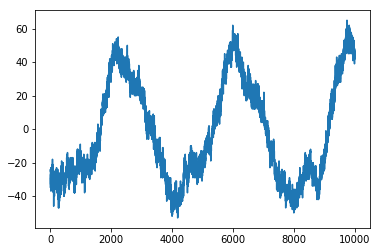

In [1010]:
plt.plot(A.wav[10000:20000])

552000


516032

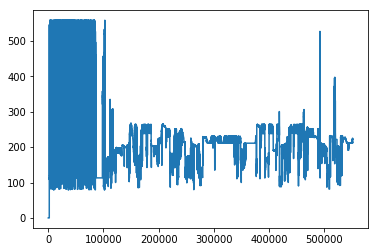

In [1011]:
plt.plot(A.real_freq)
print(len(A.real_freq))
64504*8

552000


516032

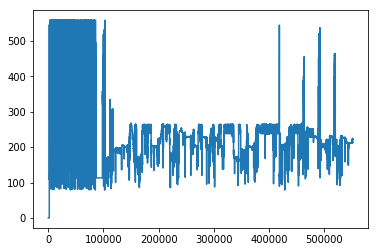

In [1023]:
plt.plot(A.real_freq)
print(len(A.real_freq))
64504*8

In [1043]:
A.build_output(mod_type='identity')
sd.play(A.output, 44100)

In [1047]:
A.build_output(mod_type='linear', start_freq=80, end_freq=400)
sd.play(A.output, 44100)

In [1045]:
A.build_output(mod_type='vibrato', vib_freq=10, amp=20)
sd.play(A.output, 44100)

In [1016]:
A.build_output(mod_type='vibrato build', vib_freq=6, amp=20)
sd.play(A.output, 44100)

In [ ]:
A.build_output(mod_type='vibratoflat', vib_freq=6, amp=20)
sd.play(A.output, 44100)

In [1046]:
A.build_output(mod_type='constant', freq=180.81)
sd.play(A.output, 44100)

In [1020]:
A.build_output(mod_type='note')
sd.play(A.output, 44100)

In [785]:
des = np.ones_like(A.real_freq)*130.81
des[85000:] = 220.00 #A3
des[95000:] = 196.00 #G3
des[160000:180000] = 174.61 #F3
A.build_output(mod_type='custom', desired=des)
sd.play(A.output, 44100)

In [784]:
# high

des = np.ones_like(A.real_freq)*261.63 #C4
des[85000:] = 440.00 #A4
des[97000:] = 392.00 #G4
des[160000:180000] = 349.23 #F4
A.build_output(mod_type='custom', desired=des)
sd.play(A.output, 44100)

In [759]:
sd.play(A.output, 44100)

In [964]:
sd.play(A.wav, 44100)

In [1047]:
print('Orig:', len(A.wav))
print('Diff:', len(ot))

Orig: 127442
Diff: 127442


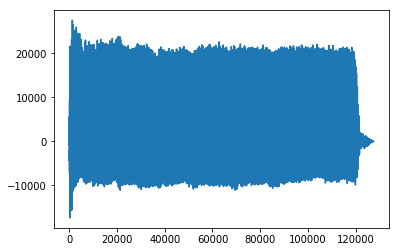

In [1049]:
plt.plot(A.wav)

In [447]:
# indx of dwnsmpld to freq
dsf = (44100/8) #samp/sec
indx = 55 # samps
freq = 1/(indx/dsf)
freq

100.22727272727273

In [446]:
# indx of dwnsmpld to freq
dsf = (44100) #samp/sec
indx = (70)*8 # samps
freq = 1/(indx/dsf)
freq

78.75

In [144]:
notes = [55.00,58.2,61.74,
65.41,69.30,73.42,77.78,82.41,87.31,92.50,98.00,103.83,110.00,116.54,123.47,130.81,
138.59,146.83,155.56,164.81,174.61,185.00,196.00,207.65,220.00,233.08,246.94,261.63,
277.18,293.66,311.13,329.63,349.23,369.99,392.00,415.30,440.00,466.16,493.88,523.25,
554.37,587.33,622.25,659.25,698.46,739.99,783.99,830.61,880.00,932.33,987.77,1046.50]

In [176]:
len(notes)

52

In [913]:
fs, data = wavfile.read('lifeafterlove.wav')
LAL = AutoTune(data, sensitivity=.012)
print('done')

(95387,)
i: 48000 bigL: 304 freq: 144.5040214477212
i: 56000 bigL: 352 freq: 124.73643610182565
i: 64000 bigL: 352 freq: 124.28900845503459
i: 72000 bigL: 344 freq: 125.9672812256557
i: 80000 bigL: 344 freq: 127.42316784869978
i: 88000 bigL: 280 freq: 162.73062730627305
i: 96000 bigL: 208 freq: 211.37254901960785
i: 104000 bigL: 208 freq: 212.66988163086364
i: 112000 bigL: 496 freq: 87.32673267326733
i: 120000 bigL: 224 freq: 192.882703777336
i: 128000 bigL: 232 freq: 191.05947223316267
i: 136000 bigL: 240 freq: 190.6090373280943
i: 144000 bigL: 224 freq: 198.40490797546013
i: 152000 bigL: 216 freq: 198.567335243553
i: 160000 bigL: 248 freq: 178.14910025706942
i: 168000 bigL: 232 freq: 188.24214202561117
i: 176000 bigL: 232 freq: 193.3439617377441
i: 184000 bigL: 360 freq: 119.51219512195122
i: 192000 bigL: 216 freq: 213.04347826086956
i: 200000 bigL: 216 freq: 197.75784753363226
i: 208000 bigL: 216 freq: 196.00000000000003
i: 216000 bigL: 216 freq: 213.04347826086956
i: 224000 bigL: 2

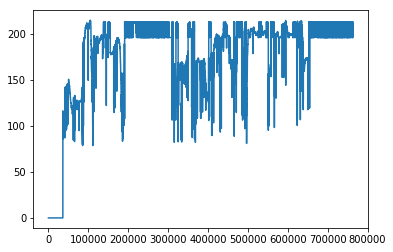

In [1070]:
plt.plot(LAL.real_freq)

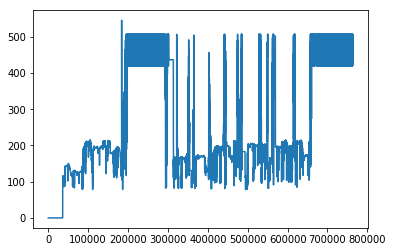

In [911]:
plt.plot(LAL.real_freq)

In [1071]:
LAL.build_output(mod_type='constant', freq=130.81)
sd.play(LAL.output, 44100)

In [1067]:
des = np.ones_like(LAL.real_freq)*130.81 # C do you be
des[85000:] = 220.00 #A3 leive
des[95000:] = 196.00 #G3 in
des[150000:170000] = 174.61 #F3 life
des[250000:] = 174.61 #F3
des[350000:360000] = 130.81
des[380000:] = 130.81
des[400000:] = 196.00 #G3
des[455000:500000] = 174.61 #F3
des[550000:570000] = 174.61 #F3
des[585000:600000] = 220.00 #A3
dn = np.linspace(220.00, 174.61, 5000)
des[620000:] = 220.00 #A3
des[630000:] = 174.61 #F3
des[630000:630000+5000]=dn
LAL.build_output(mod_type='custom', desired=des)
sd.play(LAL.output.astype(np.float64)/max(LAL.output), 44100)

In [1065]:
sd.play(LAL.wav, 44100)

In [1058]:
des = np.ones_like(LAL.real_freq)*130.81*2
des[85000:] = 220.00*2 #A3
des[95000:] = 196.00*2 #G3
des[150000:170000] = 174.61*2 #F3
des[250000:] = 174.61*2 #F3
des[350000:360000] = 130.81*2
des[380000:] = 130.81*2
des[400000:] = 196.00*2 #G3
des[455000:500000] = 174.61*2 #F3
des[550000:570000] = 174.61*2 #F3
des[585000:600000] = 220.00*2 #A3
dn = np.linspace(220.00*2, 174.61*2, 5000)
des[620000:] = 220.00*2 #A3
des[630000:] = 174.61*2 #F3
des[630000:630000+5000]=dn
LAL.build_output(mod_type='custom', desired=des)
sd.play(LAL.output, 44100)

In [1062]:
sd.play(LAL.output.astype(np.float64)/max(LAL.output), 44100)

In [1060]:
LAL.output[300000:3001000].astype(float)

array([-1., -3., -3., ...,  0.,  0.,  0.])